In [2]:
import numpy as np
from pandas.core.frame import DataFrame
import forces
from scipy.integrate import odeint
from scipy.stats import maxwell 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<h2 style="color:orange">Function to create N randomized particles</h2>

Average mass = D*V = 2e-6 * (4 * pi* (7.5e-7)**3)/3
tao = sqrt(lambda * Average Mass / A(l,n,p)) =  sqrt(2*Pi/k * Average Mass / 7.02158e-14)
Average velocity = 4KbT / 3M

In [3]:
par = {
            'l': 40,
            'x_r': 39.107,            
            'Rr': 5.6e-5, 
            'Rp':7.5e-7,
            'R_ratio':0,
            'n_w': 1.326,
            'n_p': 1.572
            }

In [4]:
lambd = 2*np.pi*par['Rr']/par['x_r']       #lamb = 2*pi / k where k = x/Rr
M = (4/3) * np.pi * (par['Rp']**3) *1040   #where density of silica is 1040
tao = 0.00048528                           #value obtained from mathematica
kbt = 1.38064852e-23 * 300                 #value is in eV
alpha = 7.02158e-14
stdevTildaV = (4*kbt*(par['Rr']**3))/(3*(2.92291e-8)*(par['Rp']**3)*lambd)
vavgTilda = np.sqrt(stdevTildaV)

eta = (0.00700175*M)/(vavgTilda*6*np.pi*(par['Rp'])*tao)#Eta is for Average Rp and Average velocity for all cartesian directions

In [23]:
def randomized(N):
    Results = pd.DataFrame(columns=['rand_x','rand_y','rand_z','rho_','theta_','phi_','dRho_','dTheta_','dPhi_','Rp_','gamma_','time_'])
    while Results.count()[0] != N:
        Rp = np.random.uniform(7.5*10**(-7) - 3.75*10**(-8), 7.5*10**(-7) + 3.75*10**(-8))
        #random positions
        rho = np.random.uniform(39.107,39.107+(2*np.pi))
        theta = np.random.uniform(((np.pi/2)-np.sqrt(1/40)),((np.pi/2)+np.sqrt(1/40)))
        phi = np.random.uniform(0,np.pi*2)
        #random velocities
        vx = np.random.normal(0,stdevTildaV)
        vy = np.random.normal(0,stdevTildaV)
        vz = np.random.normal(0,stdevTildaV)
        #rhop is density, 

        m = (4/3) * np.pi * (Rp**3) *1040
        gamma = (6 * np.pi * eta * tao * Rp)/m #gamma tilde, average tao not sepcific to size
    
        dRhodT = vx*np.sin(theta)*np.cos(phi)+vy*np.sin(theta)*np.sin(phi)+vz*np.cos(theta) #vrho 
        if dRhodT <= 0: #try more numbers forward trajectory of one of the particles 
            Results = pd.concat([pd.DataFrame([[-0.001421,  0.006615,  0.001120,  39.351469,  1.654382,  4.081736, -0.004582,0,0,Rp,0.071851,None]],columns = Results.columns),Results],ignore_index = True)
    return Results

<h2 style="color:deeppink">ODE Solver Function</h2>

In [24]:
TC = []
def f(u, t, par, gamma):
        rho, drho, theta, dtheta, phi, dphi = u
        dudt = [
                drho, forces.rho(rho, theta, par) - gamma * drho + rho * (dtheta * np.cos(phi)) ** 2 + rho * dphi ** 2,
                dtheta, (forces.theta(rho, theta, par) - gamma * rho * dtheta * np.cos(phi) - 2 * drho * dtheta * np.cos(phi) + 2 * rho * dtheta * dphi * np.sin(phi)) / (rho * np.cos(phi)),
                dphi, (forces.phi(rho, theta, par) - gamma * rho * dphi - 2 * drho * dphi - rho * dphi ** 2 * np.sin(phi) * np.cos(phi)) / rho
            ]
        if rho <= 39.107: #and theta <= (np.pi/2 + 0.01) and theta >= (np.pi - 0.01):
            TC.append(t)
            return [None,None,None,None,None,None]
        return dudt

<span style="color:red">Check</span>

In [37]:

def solve(Results):
    global TC
    j = 0
    time = np.linspace(0,200,200)
    while j != len(Results.index):
        gamma_ = Results['gamma_'][j]
        par['R_ratio'] = (Results['Rp_'][j])/(5.6*10**(-5))   
        u0 = [Results['rho_'][j],Results['dRho_'][j], Results['theta_'][j], Results['dTheta_'][j], Results['phi_'][j], Results['dPhi_'][j]] 
        sol = odeint(f, u0, time, args = (par, gamma_))
        if len(TC) != 0:
            Results.at[j,'time_'] = TC[0]
            TC = []
        j+=1
    return Results


In [38]:
h = pd.DataFrame(columns=['rand_x', 'rand_y', 'rand_z', 'rho_', 'theta_', 'phi_', 'dRho_',
       'dTheta_', 'dPhi_', 'Rp_', 'gamma_', 'time_'])

while(len(h.index) <= 2000):
    F = randomized(10)
    z = solve(F).dropna()
    h = pd.concat([z, h],ignore_index = True)

print(h)


        rand_x    rand_y   rand_z       rho_    theta_      phi_     dRho_  \
0    -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   
1    -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   
2    -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   
3    -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   
4    -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   
...        ...       ...      ...        ...       ...       ...       ...   
2005 -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   
2006 -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   
2007 -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   
2008 -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   
2009 -0.001421  0.006615  0.00112  39.351469  1.654382  4.081736 -0.004582   

     dTheta_ dPhi_           Rp_    gamma_     time_  
0       

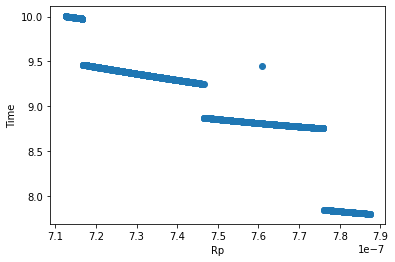

In [36]:
plt.plot(h['Rp_'],h['time_'],"o")
plt.xlabel('Rp')
plt.ylabel('Time')
plt.show()

<h3 style="color:blue">Histogram</h3>

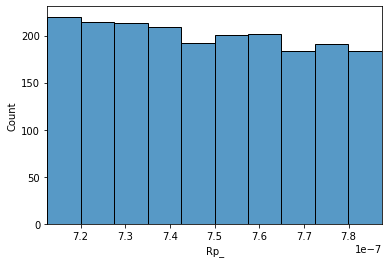

In [39]:
fig, ax = plt.subplots()
sns.histplot(h['Rp_'], bins = 10, ax = ax)
ax.set_xlim(7.5*10**(-7)-3.75*10**(-8), 7.5*10**(-7)+3.75*10**(-8))
plt.show()

<h3 style="color:green">Individual Trajectories</h3>

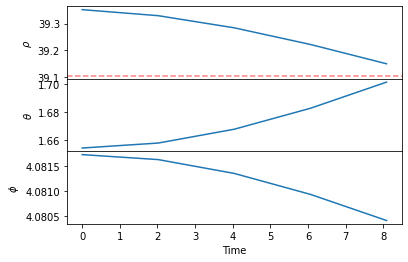

In [34]:
time = np.linspace(0,200,100)
gamma_ =  0.071851
u0 = [39.351469,-0.004582 , 1.654382, 0, 4.081736, 0] 
sol = odeint(f, u0, time, args = (par, gamma_))

def indi(sol, time):
    fig = plt.figure()
    gs = fig.add_gridspec(3, hspace = 0)
    axs = gs.subplots(sharex = True)
    axs[0].plot(time, sol[:, 0], markersize = 2)
    #show resonator's surface
    axs[0].axhline(par['x_r'], ls = 'dashed', alpha = 0.5, color = 'red')
    axs[0].set_ylabel(r'$\rho$')
    axs[1].plot(time, sol[:, 2], markersize = 2)
    axs[1].set_ylabel(r'$\theta$')
    axs[2].plot(time, sol[:, 4], markersize = 2)
    axs[2].set_ylabel(r'$\phi$')

    for ax in axs:
        ax.label_outer()
        
    plt.xlabel('Time')
    plt.show()

indi(sol,time)